In [18]:
!pip install opencv-python scikit-learn numpy matplotlib ## installing for the bsic data exploration form and functions utilizations

In [ ]:
### >Data exploration and the data preprocessing

# Importing required libraries
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Loading the  images following with  labels from dataset
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):

        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

# Visualizinf the counterfeitied ad the  original images dataset
def visualize_samples(original_images, counterfeit_images, num_samples=5):
    fig, ax = plt.subplots(2, num_samples, figsize=(15, 6))

    for i in range(num_samples):
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, i].set_title("Original")

        ax[1, i].imshow(counterfeit_images[i], cmap='gray')
        ax[1, i].axis('off')
        ax[1, i].set_title("Counterfeit")

    plt.tight_layout()

    plt.show()

## concept folows up the pixel intensity distribution
def analyze_data_distribution(images):
    intensities = [img.flatten() for img in images]  # Flatten images to 1D for analysis
    intensities = np.concatenate(intensities)

    # Ploting Distribution
    plt.figure(figsize=(8, 6))
    plt.hist(intensities, bins=256, range=(0, 256), color='gray', alpha=0.7)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

def edge_detection(images):
    edge_images = []
    for img in images:
        edges = cv2.Canny(img, 100, 200)  # Using Canny edge detection for the gettting the edges fetaure extraction
        edge_images.append(edges)
    return edge_images

original_path = '/content/first_print'  # Replace with path to Original QR Codes images or prints
counterfeit_path = '/content/Secondprint'  # Replace with path to counterfeited QR Codes images or prints


original_images, original_labels = load_images_from_folder(original_path, 0)  # 0 for the Original images
counterfeit_images, counterfeit_labels = load_images_from_folder(counterfeit_path, 1)  # 1 for Counterfeited images

# Visualize a set of QR code samples
visualize_samples(original_images, counterfeit_images)

# Perform analysis (PID)
print("Analyzing Original QR Code Images")
analyze_data_distribution(original_images)
print("Analyzing Counterfeit QR Code Images")
analyze_data_distribution(counterfeit_images)

# Simple Feature Extraction by only the Edge Detection
original_edge_images = edge_detection(original_images)
counterfeit_edge_images = edge_detection(counterfeit_images)

# Visualization of features
def visualize_edge_detection(original_edge_images, counterfeit_edge_images, num_samples=5):

    fig, ax = plt.subplots(2, num_samples, figsize=(15, 6))

    for i in range(num_samples):
        ax[0, i].imshow(original_edge_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, i].set_title("Original - Edges")

        ax[1, i].imshow(counterfeit_edge_images[i], cmap='gray')
        ax[1, i].axis('off')
        ax[1, i].set_title("Counterfeit - Edges")

    plt.tight_layout()
    plt.show()

# calling the visualize function
visualize_edge_detection(original_edge_images, counterfeit_edge_images)


In [ ]:
### Going in depth with the more feature extraction

## First with Brightness and contrast
def calculate_brightness_contrast(images):
    brightness = []
    contrast = []
    for img in images:

        brightness.append(np.mean(img))

        contrast.append(np.std(img))

    return np.array(brightness), np.array(contrast)

## Second with texture metrics
from skimage.feature import local_binary_pattern
from skimage import img_as_float

def extract_texture_features(images, radius=1, n_points=8):
    textures = []
    for img in images:

        img = img_as_float(img)   # image to float conversion


        lbp = local_binary_pattern(img, n_points, radius, method='uniform')   # Extracting LBP texture features

        # Calculate the histogram
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        lbp_hist = lbp_hist.astype('float')
        lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize histogram

        textures.append(lbp_hist)

    return np.array(textures)

# Feature extraction for CDP degradation (Local pattern)
def extract_cdp_degradation_features(images):
    cdp_degradation = []
    for img in images:
        # Simple method for simulating CDP degradation
        # Calculate the difference between the original image and a blurred version
        blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
        degradation = np.sum(np.abs(img - blurred_img)) / img.size
        cdp_degradation.append(degradation)

    return np.array(cdp_degradation)

# Extracting global features
#brightness and contrast
brightness_original, contrast_original = calculate_brightness_contrast(original_images)
brightness_counterfeit, contrast_counterfeit = calculate_brightness_contrast(counterfeit_images)
texture_original = extract_texture_features(original_images) # using LBP for both
texture_counterfeit = extract_texture_features(counterfeit_images)

# Extract CDP degradation features
cdp_degradation_original = extract_cdp_degradation_features(original_images)
cdp_degradation_counterfeit = extract_cdp_degradation_features(counterfeit_images)

# Combining all features into one feature set

features_original = np.column_stack([brightness_original, contrast_original, texture_original, cdp_degradation_original])
features_counterfeit = np.column_stack([brightness_counterfeit, contrast_counterfeit, texture_counterfeit, cdp_degradation_counterfeit])



features = np.concatenate([features_original, features_counterfeit], axis=0) # Combining the original and counterfeit features

# Combining  the labels
labels = np.concatenate([np.zeros(len(features_original)), np.ones(len(features_counterfeit))], axis=0)

# Saving  the feature dataset (for later model training)
np.save('features.npy', features)
np.save('labels.npy', labels)

# Visualizing engineered features
def visualize_features(features, labels, num_samples=5):
    fig, ax = plt.subplots(2, num_samples, figsize=(15, 6))

    for i in range(num_samples):
        ax[0, i].bar(range(len(features[i])), features[i], color='blue')
        ax[0, i].set_title(f"Original - Sample {i+1}")



        ax[1, i].bar(range(len(features[i+len(features_original)])), features[i+len(features_original)], color='red')
        ax[1, i].set_title(f"Counterfeit - Sample {i+1}")

    plt.tight_layout()
    plt.show()

## calling the Vzlzng function
visualize_features(features, labels)


Best hyperparameters for SVM: {'C': 10, 'degree': 3, 'gamma': 'auto'}
SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        31
         1.0       0.97      0.97      0.97        29

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

Best hyperparameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        31
         1.0       1.00      0.90      0.95        29

    accuracy                           0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



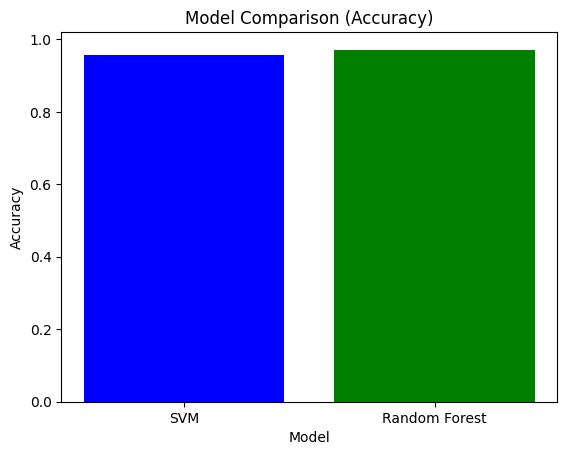

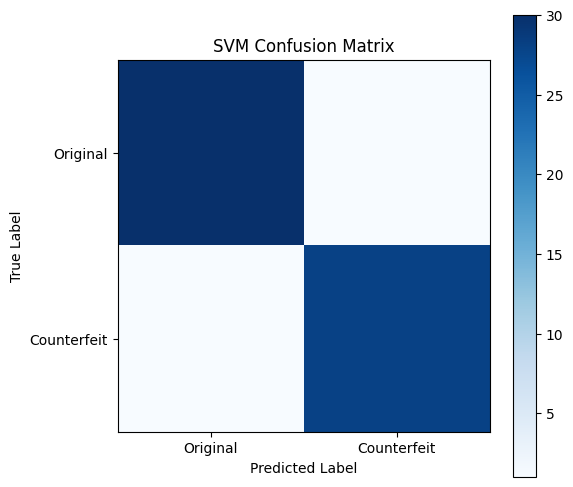

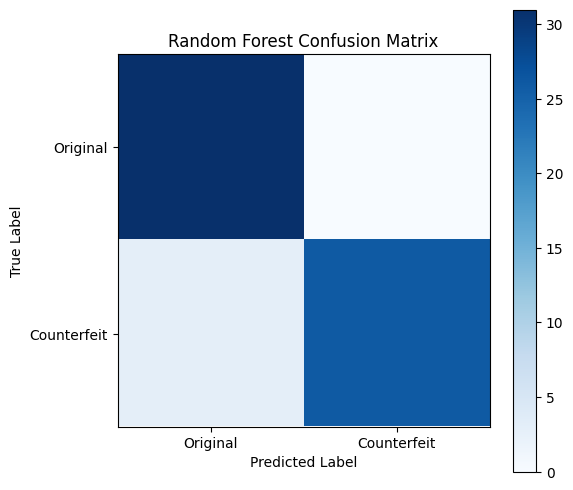

In [21]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Loadingthe features and labels from previously saved data
features = np.load('features.npy')
labels = np.load('labels.npy')

# Preprocessing
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Feature selection using PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
features_pca = pca.fit_transform(features_scaled)

# Train-test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.3, random_state=42)

# Model 1: SVM with GridSearchCV for hyperparameter tuning
svm_model = SVC(kernel='poly', random_state=42)

# Hyperparameter tuning for SVM using GridSearchCV
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5, n_jobs=-1)
svm_grid_search.fit(X_train, y_train)
print("Best hyperparameters for SVM:", svm_grid_search.best_params_)


svm_best_model = svm_grid_search.best_estimator_
y_pred_svm = svm_best_model.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

print("Best hyperparameters for Random Forest:", rf_grid_search.best_params_)

rf_best_model = rf_grid_search.best_estimator_
y_pred_rf = rf_best_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

svm_accuracy = svm_grid_search.best_score_
rf_accuracy = rf_grid_search.best_score_

models = ['SVM', 'Random Forest']
accuracy_scores = [svm_accuracy, rf_accuracy]

plt.bar(models, accuracy_scores, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison (Accuracy)')
plt.show()

# Confusion matrix creation for both models
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks([0, 1], ['Original', 'Counterfeit'])
    plt.yticks([0, 1], ['Original', 'Counterfeit'])
    plt.show()

## calling plt functions
plot_confusion_matrix(y_test, y_pred_svm, title="SVM Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf, title="Random Forest Confusion Matrix")


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Best hyperparameters for Logistic Regression: {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        31
         1.0       0.97      0.97      0.97        29

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



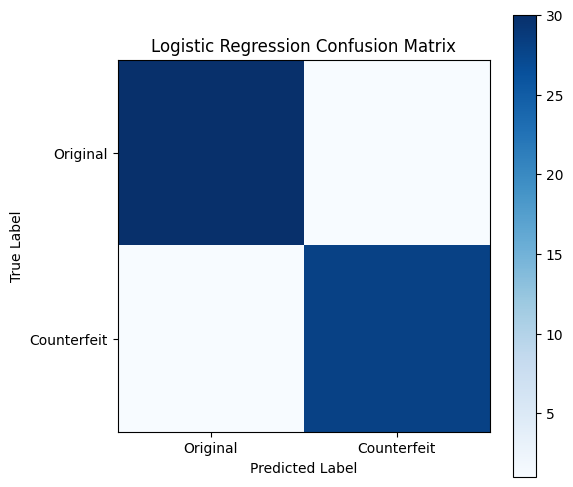

In [26]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

### applying Logistic Regression with hyp parm . tuning
def logistic_regression_model(X_train, y_train, X_test, y_test):
    lr_model = LogisticRegression(max_iter=1000, random_state=42)

    # Hypmtr tuning  using GridSearchCV
    lr_param_grid = {
        'C': [0.1, 1, 10],  # Regularization strength
        'solver': ['lbfgs', 'liblinear'],  # Optimization ssolvers
        'penalty': ['l2', 'none'],
        'class_weight': [None, 'balanced']  # Handling class imbalance
    }

    lr_grid_search = GridSearchCV(lr_model, lr_param_grid, cv=5, n_jobs=-1)
    lr_grid_search.fit(X_train, y_train)

    print("Best hyperparameters for Logistic Regression:", lr_grid_search.best_params_)

    # Evaluating
    lr_best_model = lr_grid_search.best_estimator_
    y_pred_lr = lr_best_model.predict(X_test)
    print("Logistic Regression Classification Report:")
    print(classification_report(y_test, y_pred_lr))

    # Confusion Matrix creation
    plot_confusion_matrix(y_test, y_pred_lr, title="Logistic Regression Confusion Matrix")

### ploting confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks([0, 1], ['Original', 'Counterfeit'])
    plt.yticks([0, 1], ['Original', 'Counterfeit'])
    plt.show()

## applying Logistic Regression to the feature set after PCA transformation
logistic_regression_model(X_train, y_train, X_test, y_test)



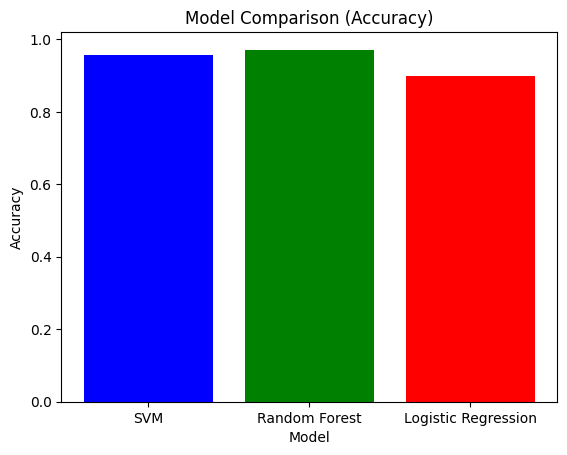

In [38]:
## model compariasion code for all three of them and random forest
models = ['SVM', 'Random Forest', 'Logistic Regression']
accuracy_scores = [svm_accuracy, rf_accuracy, lr_accuracy]

plt.bar(models, accuracy_scores, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison (Accuracy)')
plt.show()


In [39]:
# because of SVM shows the best accuraccy it is ready to use and so save it
import joblib

joblib.dump(svm_grid_search.best_estimator_, 'svm_model.pkl')
print("SVM model saved!")


SVM model saved!
